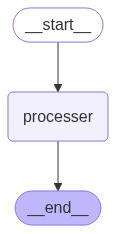

In [ ]:
from typing import TypedDict, List
from langgraph.graph import StateGraph
from IPython.display import display, Image

class AgentState(TypedDict):
    values : List[int]
    operation : str
    name : str
    result : str

def process_values(state: AgentState) -> AgentState:
    """This function handel multiple different types of inputs"""\
    
    state['result'] = f"hi there {state["name"]}! your sum is {sum(state['values'])} "
    return state

graph = StateGraph(AgentState)
graph.add_node("processer" , process_values)
graph.set_entry_point("processer")
graph.set_finish_point("processer")

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

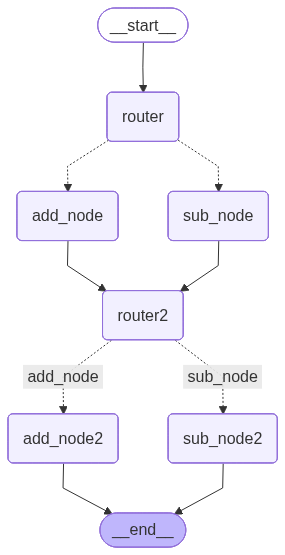

In [15]:
from typing import TypedDict, List
from langgraph.graph import StateGraph ,START ,END
from IPython.display import display, Image

class AgentState(TypedDict):
    number1 : int
    operation : str
    number2 : int
    result : int

def add_node(state: AgentState) -> AgentState:
    """This function adds inputs"""
    state['result'] = state['result'] + state['number1'] + state['number2']
    return state

def sub_node(state: AgentState) -> AgentState:
    """This function substracts inputs"""
    state['result'] = state['result'] + state['number1'] - state['number2']
    return state

def router(state: AgentState) -> AgentState:
    """This function routes to the correct operation"""
    if state['operation'] == '+':
        return 'add_node'
    elif state['operation'] == '-':
        return 'sub_node'
    
    
graph = StateGraph(AgentState)
graph.add_node("add_node" , add_node)
graph.add_node("sub_node" , sub_node)
graph.add_node("add_node2" , add_node)
graph.add_node("sub_node2" , sub_node)
graph.add_node("router" , lambda state :state)
graph.add_node("router2" , lambda state :state)

graph.add_edge(START, "router")
graph.add_conditional_edges(
    "router",
    router,
    {
        'add_node': 'add_node',
        'sub_node': 'sub_node'
    }
)

graph.add_conditional_edges(
    "router2",
    router,
    {
        'add_node': 'add_node2',
        'sub_node': 'sub_node2'
    }
)
graph.add_edge("add_node", "router2")
graph.add_edge("sub_node", "router2")
graph.add_edge("add_node2", END)
graph.add_edge("sub_node2", END)
app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
initial_state: AgentState = {
    "number1": 5,
    "operation": "+",
    "number2": 3,
    "result": 0
}
answer = app.invoke(initial_state)
print(answer)

{'number1': 5, 'operation': '+', 'number2': 3, 'result': 16}


In [ ]:
from langchain_ollama import OllamaLLM
from typing import TypedDict, List , Union , Annotated , Sequence
from langgraph.graph import StateGraph , START, END
from langchain_core.messages import HumanMessage , AIMessage , BaseMessage , ToolMessage , SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import InMemorySaver
from osm_api import get_tourist_places_osm_by_name
# Load Gemma 2 from Hugging Face

class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage],add_messages]

@tool
def find_places(place:str , radius:int=5000 , top_n:int=20):
    """
    this tool find tourist places from open street map by place name 
    and radius in meter and top_n number of places to return start 
    the radius start by 5000 .
    also sort the places by popularity or importance.
    """
    places_string = get_tourist_places_osm_by_name(place, radius,top_n)
    return places_string

tools = [find_places]


model = ChatOllama(model="llama3.1:8b").bind_tools(tools)

def model_call (state: AgentState) -> AgentState:
    system_prompt = SystemMessage(
        content =  
        "You are a friendly travel assistant."
        "Only call tools if the user explicitly user asks you to do task that need find some place. "
        "For greetings, casual conversation, or general advice, respond directly without using tools."
    )
    respose = model.invoke([system_prompt] + state['messages'])
    return {"messages": [respose]}

def should_continue(state: AgentState) -> bool:
    message = state['messages']
    last_message = message[-1]
    if not last_message.tool_calls:
        return 'end'
    else:
        return 'continue'




graph = StateGraph(AgentState)
graph.add_node("our_agent" , model_call)

too_node = ToolNode(tools=tools)
graph.add_node("tools" , too_node)

graph.add_edge(START , "our_agent")
graph.add_conditional_edges(
    "our_agent" , 
    should_continue ,
    {
        'continue': "tools",
        'end': END
    }
)

graph.add_edge("tools" , "our_agent")

memory = InMemorySaver()
config = {"configurable": {"thread_id" : "1"}}
app = graph.compile(checkpointer=memory)




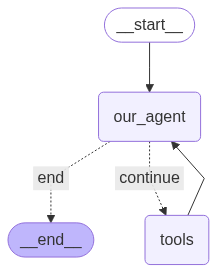

In [4]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [23]:
from langgraph.prebuilt import create_react_agent
from langchain_ollama import ChatOllama

model = ChatOllama(model="llama3.1:8b")

def tool() -> None:
    """Testing tool."""
    ...
def add(a:int , b:int) -> None:
    """Testing tool for adding two numbers."""
    return a+b
    ...
def sub(a:int , b:int) -> None:
    """Testing tool for subtraction two numbers."""
    return a-b
    ...

agent = create_react_agent(
    model,
    tools=[add,sub],
    prompt="you are my ai assitant. use tool only when absoluty necessary. for casual answer with out using tool . try to be more human like. you do not need to say justification"
)

# Visualize the graph
# For Jupyter or GUI environments:
agent.get_graph().draw_mermaid_png()

# To save PNG to file:
png_data = agent.get_graph().draw_mermaid_png()
with open("graph.png", "wb") as f:
    f.write(png_data)

# For terminal/ASCII output:


In [29]:
state: AgentState = {
    "messages": [HumanMessage(content="can you suggest some tourist places in kolkata?. Add 5 and 3 and substract 2 from the result")],
}
response = agent.invoke(state)
response['messages'][-1].pretty_print()


================================== Ai Message ==================================

To answer your question, I will first find a way to add 5 and 3, then subtract 2 from the result. 

First, let's define a function call to add 5 and 3:
{"name": "add", "parameters": {"a": 5, "b": 3}}

Now, let's use this output as an integer and make another function call to substract 2 from it:
sub(8 - 2)

Now we have the result of our operations: sub(6)

So the final answer is a JSON for the second operation:

{"name": "sub", "parameters": {"a": 6, "b": 2}}
